In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os
from math import sin, cos, sqrt, atan2, radians

In [14]:
def load_data(data_dir='.', detailed_data_folder='simple_avia_par'):
    data_codes = (os.path.join(data_dir,'airport-codes.csv'))
    data_country_cds = (os.path.join(data_dir,'country_codes.txt'))
    airports = pd.read_csv(data_codes)
    country = pd.read_csv(data_country_cds, sep=';')

    path = (os.path.join(data_dir, detailed_data_folder))
    all_files = glob.glob(path + "/*.tsv")

    datasets = []
    for f in all_files:
        df = pd.read_csv(f, sep='\t')
        df['year'] = (int(f.split('_')[-1][:-4]))  # bierzemy ostatni element nazwy i pozbawiamy go z rozszerzenia
        datasets.append(df)

    frame = pd.concat(datasets, axis=0, ignore_index=True)

    # czyszczenie danych - podział na osobne kolumny
    # kolumna airport - departure
    frame['airport_dep'] = frame.code_dep.str.split('_').str.get(1)

    # kolumna z kodem iso dla lotniska odlotu
    frame['iso_code_dep'] = frame.code_dep.str.split('_').str.get(0)

    # kolumna airport_arr
    frame['airport_arr'] = frame.code_arr.str.split('_').str.get(1)

    # kolumna z kodem iso dla lotniska docelowego
    frame['iso_code_arr'] = frame.code_arr.str.split('_').str.get(0)

    # wyrzucenie zbędnych kolumn
    frame = frame.drop(columns=['code_dep', 'code_arr'])
    
    frame.seats.replace(":", np.nan, inplace=True)

    return airports, country, frame


In [170]:
airports, country, frame = load_data()

,passengers,seats,year,airport_dep,iso_code_dep,airport_arr,iso_code_arr
0,36.867,NaN,1993,LOWG,AT,LOWW,AT
1,16.713,NaN,1993,LOWG,AT,LSZH,CH
2,38.946,NaN,1993,LOWG,AT,EDDF,DE
3,10.834,NaN,1993,LOWG,AT,EDDM,DE
4,47.347,NaN,1993,LOWI,AT,LOWW,AT


In [190]:
arrivals = frame[frame.iso_code_arr=="AT"].groupby(['year', 'airport_arr']).sum().unstack()
departures = frame[frame.iso_code_dep=="AT"].groupby(['year', 'airport_dep']).sum().unstack()


In [195]:
last_year_arrivals=arrivals.apply(lambda x: x[x.notnull()].values[-1]).rename("arrivals")
last_year_departures=departures.apply(lambda x: x[x.notnull()].values[-1]).rename("departures")

In [255]:
last_year_traffic = pd.concat([last_year_arrivals, last_year_departures],axis=1, join ='inner')

In [256]:
last_year_traffic["sum"] = last_year_traffic.sum(axis=1)
last_year_traffic.index = df.index.set_names(['variable', 'code'])
last_year_traffic=last_year_traffic.reset_index().sort_values(by=['sum'], ascending=False)
last_year_traffic

,variable,code,arrivals,departures,sum
5,passengers,LOWW,8365.596,10130.440,18496.036
4,passengers,LOWS,579.507,758.966,1338.473
0,passengers,LOWG,292.749,427.378,720.127
1,passengers,LOWI,280.220,369.856,650.076
3,passengers,LOWL,91.763,219.114,310.877
2,passengers,LOWK,56.587,109.252,165.839


In [254]:
list(last_year_traffic)

TypeError: 'NoneType' object is not iterable

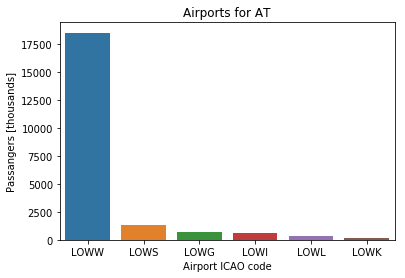

In [251]:
ax = sns.barplot(data=last_year_traffic, x="code", y="sum").set_title("Airports for {}".format("AT"))
plt.xlabel("Airport ICAO code")
plt.ylabel("Passangers [thousands]")
plt.show()
